In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "CPP"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [7]:
USE_FULL_DF = True

if USE_FULL_DF:
    dataset = pd.read_csv(df_path)
else:
    dataset_ = pd.read_csv(df_path)
    r = min(5000/len(dataset_), 1)
    _, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)
dataset.head()

,id,sequence,length,class
0,Achn014051,MGEERERESESESEACGRGGPVMDTPVRNQIAAPGSQFEESPVFNY...,773,1
1,Achn050881,MEVNDSATKEQKPCKCKQSRCVKLYCECFSSGTYCEGCRCINCQNN...,389,1
2,Achn065621,MGQSVFGLLRGCERWGLGRKGATAAEGCENFGLRSGTAHKDEFNCL...,345,1
3,Achn069971,MYQMNLREGFRNSSHKEIYIYKYISIKSCPFIGSPITSNSPKSTTN...,639,1
4,Achn146311,MEKGEGGDFSPKTDQSDTLPDFPAKKLARQLDFTGFSGASGTVVLP...,553,1


In [8]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [9]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".keras", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [10]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
1746,0.019447,0.000000,0.001024,0.002047,0.000000,0.006141,0.000000,0.008188,0.001024,0.011259,...,0.001024,0.001024,0.000000,0.001024,0.001024,0.002047,0.0,0.0,0.0,0.000000
2293,0.004320,0.002160,0.006479,0.000000,0.000000,0.002160,0.002160,0.002160,0.004320,0.004320,...,0.000000,0.000000,0.002160,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
1549,0.011765,0.001681,0.005042,0.003361,0.001681,0.001681,0.001681,0.003361,0.005042,0.006723,...,0.000000,0.000000,0.000000,0.001681,0.001681,0.000000,0.0,0.0,0.0,0.000000
2672,0.000000,0.002506,0.002506,0.007519,0.002506,0.000000,0.000000,0.005013,0.000000,0.000000,...,0.000000,0.002506,0.002506,0.000000,0.002506,0.000000,0.0,0.0,0.0,0.005013
872,0.021452,0.000000,0.001650,0.003300,0.001650,0.011551,0.000000,0.006601,0.003300,0.004950,...,0.000000,0.000000,0.000000,0.003300,0.003300,0.001650,0.0,0.0,0.0,0.000000


In [11]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (2558, 441)
X_test: (640, 441)
y_train: (2558,)
y_test: (640,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [12]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 14s 465ms/step - accuracy: 0.5469 - loss: 0.6930

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5405 - loss: 0.6878 - val_accuracy: 0.8145 - val_loss: 0.6010


Epoch 2/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6875 - loss: 0.6142

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8840 - loss: 0.4956 - val_accuracy: 0.9785 - val_loss: 0.1266


Epoch 3/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9688 - loss: 0.2022

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9725 - loss: 0.1212 - val_accuracy: 0.9824 - val_loss: 0.0461


Epoch 4/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9531 - loss: 0.1184

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9790 - loss: 0.0642

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9791 - loss: 0.0638 - val_accuracy: 0.9863 - val_loss: 0.0397


Epoch 5/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9688 - loss: 0.0778

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9878 - loss: 0.0449

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9877 - loss: 0.0451 - val_accuracy: 0.9922 - val_loss: 0.0279


Epoch 6/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0054

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9864 - loss: 0.0347

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9868 - loss: 0.0340 - val_accuracy: 0.9922 - val_loss: 0.0259


Epoch 7/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0046

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9930 - loss: 0.0239

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9931 - loss: 0.0238 - val_accuracy: 0.9941 - val_loss: 0.0223


Epoch 8/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9688 - loss: 0.0354

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9921 - loss: 0.0137

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9922 - loss: 0.0137 - val_accuracy: 0.9922 - val_loss: 0.0213


Epoch 9/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0020

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9981 - loss: 0.0097

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9981 - loss: 0.0097 - val_accuracy: 0.9941 - val_loss: 0.0195


Epoch 10/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0017

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9962 - loss: 0.0134

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9962 - loss: 0.0132 - val_accuracy: 0.9941 - val_loss: 0.0209


Epoch 11/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.3741e-04

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0044    

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0044 - val_accuracy: 0.9941 - val_loss: 0.0230


Epoch 12/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0027

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0074

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0074 - val_accuracy: 0.9941 - val_loss: 0.0259


Epoch 13/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0022

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9917 - loss: 0.0223

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9916 - loss: 0.0225 - val_accuracy: 0.9922 - val_loss: 0.0191


Epoch 14/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0011

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0055

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0056 - val_accuracy: 0.9922 - val_loss: 0.0193


Epoch 15/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.6915e-04

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0022    

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0022 - val_accuracy: 0.9922 - val_loss: 0.0260


Epoch 16/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0010

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9999 - loss: 0.0018

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9999 - loss: 0.0018 - val_accuracy: 0.9941 - val_loss: 0.0231


Epoch 17/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.2584e-04

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0029    

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0028 - val_accuracy: 0.9941 - val_loss: 0.0205



[Train Accuracy: 99.95% - Test Accuracy: 98.59%]


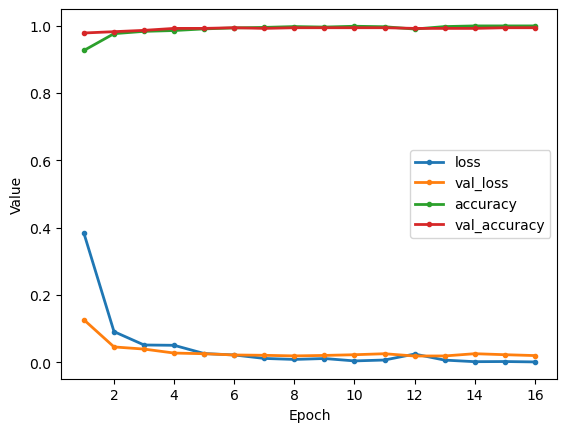

In [13]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [14]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k2, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step


 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [15]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
1746,0.006148,0.0,0.0,0.0,0.0,0.000000,0.0,0.002049,0.000000,0.003074,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2293,0.000000,0.0,0.0,0.0,0.0,0.002165,0.0,0.000000,0.002165,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1549,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.001684,0.000000,0.001684,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2672,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.002513,0.0,0.002513,0.0,0.0,0.0,0.0,0.0
872,0.008264,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.003306,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [16]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (2558, 8639)
X_test: (640, 8639)
y_train: (2558,)
y_test: (640,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [17]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,211,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,255,105 (8.60 MB)

 Trainable params: 2,255,105 (8.60 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 14s 482ms/step - accuracy: 0.4375 - loss: 0.6932

 9/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4775 - loss: 0.6931   

18/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4884 - loss: 0.6926

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4926 - loss: 0.6916

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5018 - loss: 0.6901 - val_accuracy: 0.6777 - val_loss: 0.6336


Epoch 2/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7188 - loss: 0.6325

10/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8210 - loss: 0.6112 

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8498 - loss: 0.5824

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8709 - loss: 0.5480

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8802 - loss: 0.5286 - val_accuracy: 0.9863 - val_loss: 0.1573


Epoch 3/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9844 - loss: 0.1404

10/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9933 - loss: 0.1223 

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9931 - loss: 0.1047

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9929 - loss: 0.0926

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9928 - loss: 0.0873 - val_accuracy: 0.9941 - val_loss: 0.0242


Epoch 4/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0307

 9/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9990 - loss: 0.0265 

18/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9977 - loss: 0.0219

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9975 - loss: 0.0191

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9975 - loss: 0.0178 - val_accuracy: 0.9941 - val_loss: 0.0125


Epoch 5/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0028

10/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0034 

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0039

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9998 - loss: 0.0040

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9998 - loss: 0.0040 - val_accuracy: 0.9941 - val_loss: 0.0131


Epoch 6/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0042

10/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0037 

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0034

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0032

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 0.9941 - val_loss: 0.0122


Epoch 7/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 6.3016e-04

 9/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0015     

17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0015

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0014

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9902 - val_loss: 0.0251


Epoch 8/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 5.5248e-04

10/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.7648e-04 

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.8875e-04

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.0407e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.1695e-04 - val_accuracy: 0.9922 - val_loss: 0.0175


Epoch 9/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 4.9574e-04

10/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0016     

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0014

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0013

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9902 - val_loss: 0.0218


Epoch 10/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 2.0627e-04

10/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.5280e-04 

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.1321e-04

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.5764e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.7429e-04 - val_accuracy: 0.9980 - val_loss: 0.0096


Epoch 11/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 5.7824e-04

10/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.8204e-04 

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.8215e-04

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.7912e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.7484e-04 - val_accuracy: 0.9902 - val_loss: 0.0272


Epoch 12/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0042

10/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0014 

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0010

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.3849e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.7759e-04 - val_accuracy: 0.9922 - val_loss: 0.0155


Epoch 13/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 9.5076e-05

10/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7805e-04 

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.3328e-04

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.6725e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.7994e-04 - val_accuracy: 0.9941 - val_loss: 0.0105


Epoch 14/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 2.7714e-04

10/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.7469e-04 

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.4502e-04

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.2707e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2656e-04 - val_accuracy: 0.9922 - val_loss: 0.0204


Epoch 15/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 1.2637e-04

10/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.3527e-04 

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.6099e-04

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.5691e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.5215e-04 - val_accuracy: 0.9941 - val_loss: 0.0167


Epoch 16/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 7.8276e-05

10/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0167e-04 

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0805e-04

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1193e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1289e-04 - val_accuracy: 0.9922 - val_loss: 0.0189


Epoch 17/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 8.0069e-05

10/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.1358e-05 

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0407e-04

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0854e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0809e-04 - val_accuracy: 0.9922 - val_loss: 0.0185


Epoch 18/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 6.0867e-05

10/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.8774e-05 

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.8380e-05

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2647e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.4572e-04 - val_accuracy: 0.9961 - val_loss: 0.0065


Epoch 19/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 3.6783e-04

 9/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.0535e-04 

18/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.9861e-04

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.9861e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.9476e-04 - val_accuracy: 0.9922 - val_loss: 0.0250


Epoch 20/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 1.7960e-05

10/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.7312e-05 

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.7469e-05

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.3529e-05

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.1433e-05 - val_accuracy: 0.9922 - val_loss: 0.0277



[Train Accuracy: 100.00% - Test Accuracy: 99.06%]


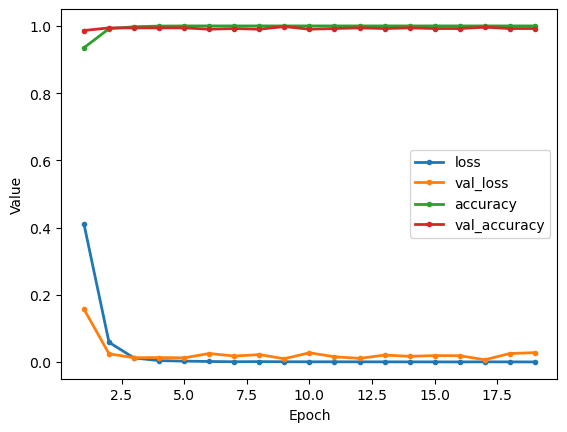

In [18]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [19]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k3, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step


 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [20]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
1746,0.002051,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001026,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2293,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1549,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2672,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
872,0.006623,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [22]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      34,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,139,393 (130.23 MB)

 Trainable params: 34,139,393 (130.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 20s 659ms/step - accuracy: 0.4375 - loss: 0.6932

 2/32 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.4844 - loss: 0.6929 

 3/32 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.5017 - loss: 0.6928

 4/32 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.5101 - loss: 0.6927

 5/32 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.5124 - loss: 0.6926

 6/32 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.5160 - loss: 0.6925

 7/32 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.5156 - loss: 0.6926

 8/32 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.5161 - loss: 0.6925

 9/32 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.5151 - loss: 0.6925

10/32 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.5136 - loss: 0.6926

11/32 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.5117 - loss: 0.6926

12/32 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.5098 - loss: 0.6926

13/32 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.5081 - loss: 0.6927

14/32 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.5065 - loss: 0.6927

15/32 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.5049 - loss: 0.6926

16/32 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.5038 - loss: 0.6926

17/32 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.5032 - loss: 0.6925

18/32 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.5027 - loss: 0.6925

19/32 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.5022 - loss: 0.6924

20/32 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.5019 - loss: 0.6923

21/32 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.5018 - loss: 0.6921

22/32 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.5013 - loss: 0.6920

23/32 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.5010 - loss: 0.6919

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.5007 - loss: 0.6917

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.5005 - loss: 0.6916

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.5007 - loss: 0.6914

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.5011 - loss: 0.6912

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.5016 - loss: 0.6911

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.5025 - loss: 0.6908

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.5036 - loss: 0.6906

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.5049 - loss: 0.6903

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.5062 - loss: 0.6901

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - accuracy: 0.5075 - loss: 0.6898 - val_accuracy: 0.7422 - val_loss: 0.6349


Epoch 2/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.7656 - loss: 0.6280

 2/32 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.7578 - loss: 0.6266

 3/32 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.7535 - loss: 0.6260

 4/32 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.7536 - loss: 0.6241

 5/32 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.7547 - loss: 0.6222

 6/32 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.7592 - loss: 0.6198

 7/32 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.7623 - loss: 0.6176

 8/32 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.7642 - loss: 0.6156

 9/32 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.7661 - loss: 0.6131

10/32 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.7678 - loss: 0.6106

11/32 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.7694 - loss: 0.6084

12/32 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.7710 - loss: 0.6062

13/32 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.7726 - loss: 0.6041

14/32 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.7748 - loss: 0.6020

15/32 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.7773 - loss: 0.5998

16/32 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.7798 - loss: 0.5977

17/32 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.7825 - loss: 0.5954

18/32 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.7853 - loss: 0.5930

19/32 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.7883 - loss: 0.5904

20/32 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.7910 - loss: 0.5878

21/32 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.7935 - loss: 0.5853

22/32 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.7959 - loss: 0.5826

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.7982 - loss: 0.5800

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.8005 - loss: 0.5772

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.8028 - loss: 0.5744

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.8051 - loss: 0.5716

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.8072 - loss: 0.5688

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.8094 - loss: 0.5660

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.8115 - loss: 0.5632

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.8135 - loss: 0.5604

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.8156 - loss: 0.5576

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.8175 - loss: 0.5548

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 0.8194 - loss: 0.5521 - val_accuracy: 0.9844 - val_loss: 0.2755


Epoch 3/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 6s 205ms/step - accuracy: 1.0000 - loss: 0.2753

 2/32 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 0.2623

 3/32 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.9983 - loss: 0.2578

 4/32 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.9967 - loss: 0.2547

 5/32 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.9955 - loss: 0.2504

 6/32 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.9950 - loss: 0.2463

 7/32 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9947 - loss: 0.2415

 8/32 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9942 - loss: 0.2381

 9/32 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9935 - loss: 0.2351

10/32 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.9930 - loss: 0.2319

11/32 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.9928 - loss: 0.2285

12/32 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.9924 - loss: 0.2254

13/32 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.9920 - loss: 0.2224

14/32 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.9917 - loss: 0.2194

15/32 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9915 - loss: 0.2164

16/32 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9914 - loss: 0.2135

17/32 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.9913 - loss: 0.2107

18/32 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.9912 - loss: 0.2079

19/32 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.9912 - loss: 0.2052

20/32 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.9912 - loss: 0.2024

21/32 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.9913 - loss: 0.1997

22/32 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.9913 - loss: 0.1970

23/32 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.9914 - loss: 0.1944

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9914 - loss: 0.1918

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9915 - loss: 0.1893

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9916 - loss: 0.1869

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9916 - loss: 0.1844

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9917 - loss: 0.1820

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9918 - loss: 0.1797

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9919 - loss: 0.1775

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9920 - loss: 0.1752

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9920 - loss: 0.1731

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.9921 - loss: 0.1710 - val_accuracy: 0.9863 - val_loss: 0.0419


Epoch 4/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 0.0129

 2/32 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 0.0145

 3/32 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 0.0151

 4/32 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 0.0149

 5/32 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 0.0146

 6/32 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 0.0146

 7/32 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 0.0145

 8/32 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 0.0143

 9/32 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 0.0141

10/32 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 0.0139

11/32 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 0.0137

12/32 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 0.0136

13/32 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 0.0134

14/32 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 0.0132

15/32 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 0.0130

16/32 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 0.0129

17/32 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 0.0127

18/32 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 0.0126

19/32 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 0.0124

20/32 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 0.0123

21/32 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 0.0122

22/32 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 0.0120

23/32 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 0.0119

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 0.0118

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 0.0117

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 0.0116

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 0.0115

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 0.0114

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9999 - loss: 0.0113

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9999 - loss: 0.0112

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9999 - loss: 0.0111

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9999 - loss: 0.0110

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.9999 - loss: 0.0109 - val_accuracy: 0.9902 - val_loss: 0.0263


Epoch 5/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 0.0022

 2/32 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 1.0000 - loss: 0.0021

 3/32 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 1.0000 - loss: 0.0021

 4/32 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 1.0000 - loss: 0.0021

 5/32 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 0.0021

 6/32 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 0.0021

 7/32 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 0.0022

 8/32 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 0.0022

 9/32 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 0.0022

10/32 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 1.0000 - loss: 0.0022

11/32 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 0.0022

12/32 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 0.0022

13/32 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 0.0022

14/32 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 0.0023

15/32 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 0.0023

16/32 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 0.0023

17/32 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 0.0023

18/32 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 0.0023

19/32 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 0.0024

20/32 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 0.0024

21/32 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 0.0024

22/32 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 0.0024

23/32 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 0.0024

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 0.0024

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 0.0024

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 0.0024

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 0.0024

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 0.0024

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 0.0024

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 0.0024

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 0.0024

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 0.0024

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 0.9902 - val_loss: 0.0192


Epoch 6/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 1.0000 - loss: 0.0012

 2/32 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 1.0000 - loss: 0.0011

 3/32 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 1.0000 - loss: 0.0011

 4/32 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 0.0011

 5/32 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 1.0000 - loss: 0.0012

 6/32 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 0.0012

 7/32 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.9997 - loss: 0.0016

 8/32 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.9995 - loss: 0.0019

 9/32 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9993 - loss: 0.0021

10/32 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9993 - loss: 0.0022

11/32 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.9992 - loss: 0.0023

12/32 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.9991 - loss: 0.0023

13/32 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.9991 - loss: 0.0024

14/32 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.9991 - loss: 0.0024

15/32 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.9991 - loss: 0.0024

16/32 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.9991 - loss: 0.0024

17/32 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.9991 - loss: 0.0024

18/32 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.9991 - loss: 0.0024

19/32 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.9991 - loss: 0.0024

20/32 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.9991 - loss: 0.0024

21/32 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.9991 - loss: 0.0024

22/32 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.9991 - loss: 0.0024

23/32 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.9991 - loss: 0.0024

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9991 - loss: 0.0024

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9991 - loss: 0.0024

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9992 - loss: 0.0024

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9992 - loss: 0.0024

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9992 - loss: 0.0024

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9992 - loss: 0.0023

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9992 - loss: 0.0023

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9992 - loss: 0.0023

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9992 - loss: 0.0023

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.9992 - loss: 0.0023 - val_accuracy: 0.9902 - val_loss: 0.0189


Epoch 7/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 8.0784e-04

 2/32 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 1.0000 - loss: 9.0523e-04

 3/32 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 1.0000 - loss: 8.9601e-04

 4/32 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 1.0000 - loss: 9.2332e-04

 5/32 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 1.0000 - loss: 9.5984e-04

 6/32 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 1.0000 - loss: 9.8254e-04

 7/32 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 1.0000 - loss: 9.9624e-04

 8/32 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 1.0000 - loss: 0.0010    

 9/32 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 1.0000 - loss: 0.0010

10/32 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 1.0000 - loss: 0.0010

11/32 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 0.0010

12/32 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 0.0010

13/32 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 0.0010

14/32 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 0.0010

15/32 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 0.0010

16/32 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 0.0010

17/32 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 0.0010

18/32 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 0.0010

19/32 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 0.0010

20/32 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 0.0010

21/32 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 0.0010

22/32 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 0.0010

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 0.0010

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 0.0010

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 0.0010

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 0.0010

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 0.0010

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 0.0010

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 9.9784e-04

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 9.9433e-04

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 9.9173e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 9.8885e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 9.8614e-04 - val_accuracy: 0.9902 - val_loss: 0.0180


Epoch 8/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 0.0015

 2/32 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 1.0000 - loss: 0.0012

 3/32 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 1.0000 - loss: 0.0010

 4/32 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 1.0000 - loss: 9.4446e-04

 5/32 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 1.0000 - loss: 8.9002e-04

 6/32 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 1.0000 - loss: 8.5551e-04

 7/32 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 1.0000 - loss: 8.3589e-04

 8/32 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 1.0000 - loss: 8.1862e-04

 9/32 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 1.0000 - loss: 8.0580e-04

10/32 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 1.0000 - loss: 7.9348e-04

11/32 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 1.0000 - loss: 7.7976e-04

12/32 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 1.0000 - loss: 7.6881e-04

13/32 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 1.0000 - loss: 7.5772e-04

14/32 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 1.0000 - loss: 7.4793e-04

15/32 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 1.0000 - loss: 7.4053e-04

16/32 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 1.0000 - loss: 7.3342e-04

17/32 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 1.0000 - loss: 7.2629e-04

18/32 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 1.0000 - loss: 7.1893e-04

19/32 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 1.0000 - loss: 7.1129e-04

20/32 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 1.0000 - loss: 7.0404e-04

21/32 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 1.0000 - loss: 6.9687e-04

22/32 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 1.0000 - loss: 6.9024e-04

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 1.0000 - loss: 6.8391e-04

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 1.0000 - loss: 6.7825e-04

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 1.0000 - loss: 6.7256e-04

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 1.0000 - loss: 6.6713e-04

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 1.0000 - loss: 6.6184e-04

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 1.0000 - loss: 6.5747e-04

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 1.0000 - loss: 6.5308e-04

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 1.0000 - loss: 6.5285e-04

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 1.0000 - loss: 6.5246e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 1.0000 - loss: 6.5172e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 6.5103e-04 - val_accuracy: 0.9902 - val_loss: 0.0183


Epoch 9/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 6.8336e-04

 2/32 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 1.0000 - loss: 5.6914e-04

 3/32 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 1.0000 - loss: 5.3439e-04

 4/32 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 1.0000 - loss: 5.1989e-04

 5/32 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 1.0000 - loss: 5.1908e-04

 6/32 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 1.0000 - loss: 5.1785e-04

 7/32 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 1.0000 - loss: 5.1093e-04

 8/32 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 1.0000 - loss: 5.0517e-04

 9/32 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 1.0000 - loss: 5.1149e-04

10/32 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 1.0000 - loss: 5.1342e-04

11/32 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 1.0000 - loss: 5.1238e-04

12/32 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 1.0000 - loss: 5.1006e-04

13/32 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 1.0000 - loss: 5.0634e-04

14/32 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 1.0000 - loss: 5.0271e-04

15/32 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 1.0000 - loss: 4.9935e-04

16/32 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 1.0000 - loss: 4.9618e-04

17/32 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 1.0000 - loss: 4.9409e-04

18/32 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 1.0000 - loss: 4.9153e-04

19/32 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 1.0000 - loss: 4.8898e-04

20/32 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 1.0000 - loss: 4.8631e-04

21/32 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 1.0000 - loss: 4.8350e-04

22/32 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 1.0000 - loss: 4.8046e-04

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 1.0000 - loss: 4.7741e-04

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 1.0000 - loss: 4.7435e-04

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 1.0000 - loss: 4.7141e-04

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 1.0000 - loss: 4.6864e-04

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 1.0000 - loss: 4.6594e-04

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 1.0000 - loss: 4.6336e-04

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 1.0000 - loss: 4.6065e-04

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 1.0000 - loss: 4.5828e-04

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 1.0000 - loss: 4.5599e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 1.0000 - loss: 4.5381e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 4.5177e-04 - val_accuracy: 0.9902 - val_loss: 0.0176


Epoch 10/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 3.1607e-04

 2/32 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 1.0000 - loss: 3.1938e-04

 3/32 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 1.0000 - loss: 3.2717e-04

 4/32 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 1.0000 - loss: 3.2238e-04

 5/32 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 1.0000 - loss: 3.1724e-04

 6/32 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 1.0000 - loss: 3.1339e-04

 7/32 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 1.0000 - loss: 3.0726e-04

 8/32 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 1.0000 - loss: 3.0182e-04

 9/32 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 1.0000 - loss: 2.9707e-04

10/32 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 1.0000 - loss: 2.9266e-04

11/32 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 1.0000 - loss: 2.8901e-04

12/32 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 1.0000 - loss: 2.8597e-04

13/32 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 1.0000 - loss: 2.8295e-04

14/32 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 1.0000 - loss: 2.8026e-04

15/32 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 2.7771e-04

16/32 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 2.7517e-04

17/32 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 2.7279e-04

18/32 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 2.7137e-04

19/32 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 2.7006e-04

20/32 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 2.6919e-04

21/32 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 2.6848e-04

22/32 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 2.6759e-04

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 2.6663e-04

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 2.6561e-04

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 2.6508e-04

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 2.6441e-04

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 2.6388e-04

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 2.6355e-04

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 2.6324e-04

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 2.6288e-04

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 2.6245e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 2.6212e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 2.6180e-04 - val_accuracy: 0.9902 - val_loss: 0.0219


Epoch 11/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 1.8251e-04

 2/32 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 1.7657e-04

 3/32 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 1.0000 - loss: 1.8040e-04

 4/32 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 1.0000 - loss: 1.9869e-04

 5/32 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 1.0000 - loss: 2.0518e-04

 6/32 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 1.0000 - loss: 2.2324e-04

 7/32 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 1.0000 - loss: 2.3347e-04

 8/32 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 1.0000 - loss: 2.3801e-04

 9/32 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 2.4342e-04

10/32 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 2.4647e-04

11/32 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 2.4815e-04

12/32 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 2.4839e-04

13/32 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 2.4819e-04

14/32 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 2.5023e-04

15/32 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 2.5170e-04

16/32 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 2.5229e-04

17/32 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 2.5249e-04

18/32 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 2.5222e-04

19/32 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 2.5203e-04

20/32 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 2.6024e-04

21/32 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 2.6716e-04

22/32 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 2.7311e-04

23/32 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 2.7820e-04

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 2.8250e-04

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 2.8613e-04

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 2.8915e-04

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 2.9183e-04

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 2.9412e-04

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 2.9656e-04

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 2.9859e-04

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 3.0047e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 3.0208e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 3.0360e-04 - val_accuracy: 0.9941 - val_loss: 0.0107


Epoch 12/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 1.2154e-04

 2/32 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step - accuracy: 1.0000 - loss: 1.5101e-04

 3/32 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - accuracy: 1.0000 - loss: 2.0283e-04

 4/32 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - accuracy: 1.0000 - loss: 2.3432e-04

 5/32 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 1.0000 - loss: 2.6335e-04

 6/32 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 2.7908e-04

 7/32 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 1.0000 - loss: 2.8896e-04

 8/32 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 1.0000 - loss: 2.9218e-04

 9/32 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 1.0000 - loss: 2.9305e-04

10/32 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 2.9299e-04

11/32 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 2.9130e-04

12/32 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 2.8890e-04

13/32 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 1.0000 - loss: 2.8632e-04

14/32 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 1.0000 - loss: 2.8333e-04

15/32 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 1.0000 - loss: 2.8062e-04

16/32 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 2.7817e-04

17/32 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 2.7561e-04

18/32 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 2.7331e-04

19/32 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 2.7082e-04

20/32 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 2.6849e-04

21/32 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 2.6632e-04

22/32 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 2.6400e-04

23/32 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 2.6219e-04

24/32 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 2.6072e-04

25/32 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 2.5922e-04

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 2.5787e-04

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 2.5648e-04

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 2.5502e-04

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 1.0000 - loss: 2.5364e-04

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 2.5225e-04

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 2.5089e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 2.4952e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 2.4823e-04 - val_accuracy: 0.9902 - val_loss: 0.0192


Epoch 13/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 6s 206ms/step - accuracy: 1.0000 - loss: 6.0868e-05

 2/32 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 1.0000 - loss: 8.0833e-05

 3/32 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 9.5086e-05

 4/32 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 1.0000 - loss: 1.2515e-04

 5/32 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 1.3792e-04

 6/32 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 1.4562e-04

 7/32 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 1.5194e-04

 8/32 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 1.5458e-04

 9/32 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 1.5690e-04

10/32 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 1.5735e-04

11/32 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 1.5698e-04

12/32 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 1.5620e-04

13/32 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 1.5491e-04

14/32 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 1.5328e-04

15/32 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 1.5297e-04

16/32 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 1.5391e-04

17/32 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 1.5459e-04

18/32 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 1.5500e-04

19/32 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 1.5526e-04

20/32 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 1.5559e-04

21/32 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 1.5580e-04

22/32 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 1.5586e-04

23/32 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 1.5590e-04

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 1.5606e-04

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 1.5649e-04

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 1.5680e-04

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 1.5693e-04

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 1.5699e-04

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 1.5703e-04

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 1.5703e-04

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 1.5693e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 1.5675e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 1.5657e-04 - val_accuracy: 0.9902 - val_loss: 0.0206


Epoch 14/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 8.7261e-05

 2/32 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 1.3288e-04

 3/32 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 1.4099e-04

 4/32 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 1.3905e-04

 5/32 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 1.5440e-04

 6/32 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 1.6059e-04

 7/32 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 1.6226e-04

 8/32 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 1.6250e-04

 9/32 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 1.6192e-04

10/32 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 1.6445e-04

11/32 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 1.6603e-04

12/32 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 1.6693e-04

13/32 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 1.6728e-04

14/32 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 1.6770e-04

15/32 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 1.6750e-04

16/32 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 1.6723e-04

17/32 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 1.6687e-04

18/32 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 1.6635e-04

19/32 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 1.6599e-04

20/32 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 1.6538e-04

21/32 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 1.6466e-04

22/32 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 1.6388e-04

23/32 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 1.6299e-04

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 1.6205e-04

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 1.6109e-04

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 1.6016e-04

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.5923e-04

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 1.5831e-04

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.5739e-04

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 1.5645e-04

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 1.5548e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 1.5450e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 1.5358e-04 - val_accuracy: 0.9902 - val_loss: 0.0228


Epoch 15/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 6s 206ms/step - accuracy: 1.0000 - loss: 1.6161e-04

 2/32 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 1.0000 - loss: 1.2720e-04

 3/32 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 1.2468e-04

 4/32 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.2223e-04

 5/32 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 1.2089e-04

 6/32 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 1.1993e-04

 7/32 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 1.1804e-04

 8/32 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 1.1571e-04

 9/32 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 1.1397e-04

10/32 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 1.1287e-04

11/32 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 1.1243e-04

12/32 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 1.1206e-04

13/32 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 1.1156e-04

14/32 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 1.1096e-04

15/32 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 1.1028e-04

16/32 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 1.0946e-04

17/32 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 1.0866e-04

18/32 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 1.0791e-04

19/32 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 1.0748e-04

20/32 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 1.0696e-04

21/32 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 1.0681e-04

22/32 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 1.0650e-04

23/32 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 1.0618e-04

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 1.0577e-04

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.0527e-04

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.0478e-04

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.0429e-04

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.0378e-04

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.0330e-04

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.0323e-04

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.0332e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 1.0335e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 1.0337e-04 - val_accuracy: 0.9902 - val_loss: 0.0193


Epoch 16/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 5.3718e-05

 2/32 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 6.5515e-05

 3/32 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 6.7094e-05

 4/32 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 6.5145e-05

 5/32 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 6.3505e-05

 6/32 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 6.2808e-05

 7/32 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 6.1984e-05

 8/32 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 6.0947e-05

 9/32 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 5.9853e-05

10/32 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 5.9156e-05

11/32 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 5.8598e-05

12/32 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 5.8826e-05

13/32 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 5.9026e-05

14/32 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 6.1833e-05

15/32 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 6.3962e-05

16/32 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 6.5742e-05

17/32 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 6.7156e-05

18/32 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 6.8847e-05

19/32 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 7.0192e-05

20/32 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 7.1393e-05

21/32 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 7.2374e-05

22/32 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 7.3285e-05

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 1.0000 - loss: 7.4169e-05

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 1.0000 - loss: 7.5348e-05

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 1.0000 - loss: 7.6570e-05

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 7.7619e-05

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 7.8607e-05

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 7.9487e-05

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 8.0225e-05

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 8.0850e-05

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 8.1436e-05

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 8.1976e-05

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 8.2484e-05 - val_accuracy: 0.9902 - val_loss: 0.0196


Epoch 17/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 6.0874e-05

 2/32 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 1.0000 - loss: 7.1406e-05

 3/32 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 1.0000 - loss: 7.0850e-05

 4/32 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 1.0000 - loss: 6.9387e-05

 5/32 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 1.0000 - loss: 6.8300e-05

 6/32 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 1.0000 - loss: 6.7295e-05

 7/32 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 1.0000 - loss: 6.6296e-05

 8/32 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 1.0000 - loss: 6.5536e-05

 9/32 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 1.0000 - loss: 6.4672e-05

10/32 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 1.0000 - loss: 6.4362e-05

11/32 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 1.0000 - loss: 6.4696e-05

12/32 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 1.0000 - loss: 6.4754e-05

13/32 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 6.4707e-05

14/32 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 6.4719e-05

15/32 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 6.4703e-05

16/32 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 6.4625e-05

17/32 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 6.4496e-05

18/32 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 6.4613e-05

19/32 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 6.4600e-05

20/32 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 6.4693e-05

21/32 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 6.4780e-05

22/32 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 6.4888e-05

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 1.0000 - loss: 6.5644e-05

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 1.0000 - loss: 6.6256e-05

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 6.6755e-05

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 6.7139e-05

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 6.7522e-05

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 6.8001e-05

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 6.8418e-05

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 6.8798e-05

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 6.9104e-05

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 6.9364e-05

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 6.9609e-05 - val_accuracy: 0.9902 - val_loss: 0.0227


Epoch 18/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 7.5624e-05

 2/32 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 8.8402e-05

 3/32 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 8.5973e-05

 4/32 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 8.2818e-05

 5/32 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 7.9028e-05

 6/32 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 7.5911e-05

 7/32 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 7.3537e-05

 8/32 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 7.1325e-05

 9/32 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 6.9731e-05

10/32 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 6.8556e-05

11/32 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 6.7432e-05

12/32 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 6.6330e-05

13/32 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 6.5253e-05

14/32 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 6.4578e-05

15/32 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 6.3982e-05

16/32 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 6.3347e-05

17/32 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 6.2750e-05

18/32 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 6.2092e-05

19/32 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 6.1533e-05

20/32 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 6.0980e-05

21/32 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 6.0431e-05

22/32 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 5.9930e-05

23/32 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 5.9450e-05

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 5.9160e-05

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 5.9590e-05

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 5.9946e-05

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 6.0220e-05

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 6.0457e-05

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 6.0644e-05

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 6.0787e-05

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 6.0914e-05

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 6.1028e-05

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 6.1134e-05 - val_accuracy: 0.9902 - val_loss: 0.0210


Epoch 19/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 9.1469e-05

 2/32 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 1.0000 - loss: 8.5691e-05

 3/32 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 1.0000 - loss: 7.7831e-05

 4/32 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 1.0000 - loss: 7.1162e-05

 5/32 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 1.0000 - loss: 6.7206e-05

 6/32 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 1.0000 - loss: 6.4007e-05

 7/32 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 1.0000 - loss: 6.2069e-05

 8/32 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 1.0000 - loss: 6.0777e-05

 9/32 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 1.0000 - loss: 5.9948e-05

10/32 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 1.0000 - loss: 5.9083e-05

11/32 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 1.0000 - loss: 5.8353e-05

12/32 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 1.0000 - loss: 5.7756e-05

13/32 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 1.0000 - loss: 5.7308e-05

14/32 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 1.0000 - loss: 5.6987e-05

15/32 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 1.0000 - loss: 5.6562e-05

16/32 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 1.0000 - loss: 5.6524e-05

17/32 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 1.0000 - loss: 5.6432e-05

18/32 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 1.0000 - loss: 5.6360e-05

19/32 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 1.0000 - loss: 5.6213e-05

20/32 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 1.0000 - loss: 5.6155e-05

21/32 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 1.0000 - loss: 5.6005e-05

22/32 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 1.0000 - loss: 5.5809e-05

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 1.0000 - loss: 5.5578e-05

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 1.0000 - loss: 5.5430e-05

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 1.0000 - loss: 5.5277e-05

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 1.0000 - loss: 5.5252e-05

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 1.0000 - loss: 5.5212e-05

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 1.0000 - loss: 5.5185e-05

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 1.0000 - loss: 5.5141e-05

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 1.0000 - loss: 5.5140e-05

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 1.0000 - loss: 5.5155e-05

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 1.0000 - loss: 5.5125e-05

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 5.5097e-05 - val_accuracy: 0.9902 - val_loss: 0.0196


Epoch 20/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 2.4163e-05

 2/32 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 2.3510e-05

 3/32 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 1.0000 - loss: 2.6614e-05

 4/32 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 1.0000 - loss: 4.1981e-05

 5/32 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 1.0000 - loss: 5.0811e-05

 6/32 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 1.0000 - loss: 5.6148e-05

 7/32 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 1.0000 - loss: 6.0151e-05

 8/32 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 1.0000 - loss: 6.5692e-05

 9/32 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 1.0000 - loss: 6.9122e-05

10/32 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 1.0000 - loss: 7.1370e-05

11/32 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 1.0000 - loss: 7.2818e-05

12/32 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 1.0000 - loss: 7.4371e-05

13/32 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 1.0000 - loss: 7.5464e-05

14/32 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 7.6126e-05

15/32 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 1.0000 - loss: 7.6466e-05

16/32 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 1.0000 - loss: 7.6733e-05

17/32 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 1.0000 - loss: 7.6879e-05

18/32 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 1.0000 - loss: 7.7080e-05

19/32 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 7.7074e-05

20/32 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 7.6911e-05

21/32 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 7.6661e-05

22/32 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 7.6670e-05

23/32 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 7.6582e-05

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 7.6410e-05

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 7.6172e-05

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 7.6018e-05

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 7.5806e-05

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 7.5568e-05

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 7.5291e-05

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 7.5021e-05

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 7.4716e-05

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 7.4392e-05

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 7.4088e-05 - val_accuracy: 0.9902 - val_loss: 0.0172


Epoch 21/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - accuracy: 1.0000 - loss: 7.7142e-05

 2/32 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 1.0000 - loss: 7.1672e-05

 3/32 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 1.0000 - loss: 6.6625e-05

 4/32 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 1.0000 - loss: 6.3428e-05

 5/32 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 1.0000 - loss: 6.0009e-05

 6/32 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 5.7346e-05

 7/32 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 5.5193e-05

 8/32 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 5.3904e-05

 9/32 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 5.2649e-05

10/32 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 5.1408e-05

11/32 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 5.0340e-05

12/32 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 5.0400e-05

13/32 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 5.0211e-05

14/32 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 4.9970e-05

15/32 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 4.9642e-05

16/32 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 4.9376e-05

17/32 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 4.9062e-05

18/32 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 4.8874e-05

19/32 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 4.8690e-05

20/32 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 4.8475e-05

21/32 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 4.8224e-05

22/32 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 4.8019e-05

23/32 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 4.7813e-05

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 4.7582e-05

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 4.7333e-05

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 4.7077e-05

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 4.6844e-05

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 4.6623e-05

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 4.6397e-05

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 4.6239e-05

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 4.6108e-05

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 4.5966e-05

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 4.5832e-05 - val_accuracy: 0.9902 - val_loss: 0.0176



[Train Accuracy: 100.00% - Test Accuracy: 98.75%]


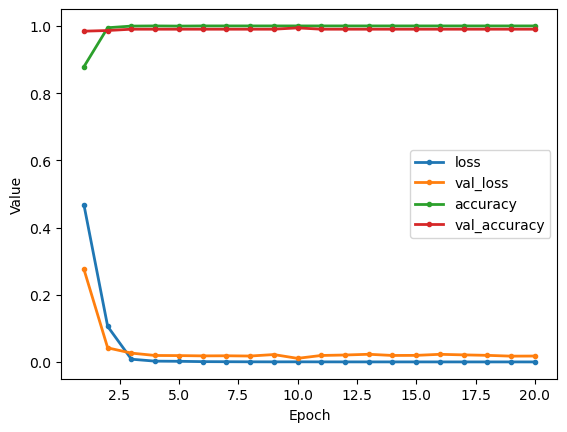

In [23]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [24]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k4, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

 7/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

13/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

 7/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

13/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [25]:
report.save()

Report saved as Output/Reports/CPP/report_32BHB6O3.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [26]:
"""k = 5
X, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()"""

"k = 5\nX, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)\nX_test.head()"

In [27]:
"""NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]"""

'NUM_CLASS  = 1\nSEQ_LENGTH = X_train.shape[1]'

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [28]:
"""name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'name="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n# Evaluate and sc

In [29]:
"""VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"""

"VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"

In [30]:
"""VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
report.save('end')"""

'VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) \nreport.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])\nreport.save(\'end\')'

In [31]:
# END

In [32]:
######################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################